In [1]:
import numpy as np
import matplotlib.style as mplstyle
mplstyle.use('fast')
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import keras
import os
import sys
import scipy
import h5py 

rippl_AI_repo = 'C:/Users/RECORDING/Athina/Github/rippl-AI'
ripple_analysis_dir = 'C:/Users/RECORDING/Athina/Ripples/'
sys.path.insert(1, rippl_AI_repo)
import rippl_AI
import aux_fcn
from importlib import reload
reload(rippl_AI)
reload(aux_fcn)

from downsample_filter_LFP import import_lfp

In [2]:
def process_LFP_new(LFP, sf, downsampled_fs, channels):
    
    ''' 
	This function processes the LFP before calling the detection algorithm.
	1. It extracts the desired channels from the original LFP, and interpolates where there is a value of -1.
	2. Downsamples the LFP to the specified downsampled_fs Hz.
	3. Normalizes each channel separately by z-scoring them.

	Mandatory inputs:
		LFP: 		LFP recorded data (np.array: n_samples x n_channels).
		sf: 		Original sampling frequency (in Hz).
        downsampled_fs: Frequency at which to downsample the data 
		channels: 	channel to which compute the undersampling and z-score normalization. Counting starts in 0. 
					If channels contains any -1, interpolation will be also applied. 
					See channels of rippl_AI.predict(), or aux_fcn.interpolate_channels() for more information.
	Output:
		LFP_norm: normalized LFP (np.array: n_samples x len(channels)). It is undersampled to 1250Hz, z-scored, 
					and transformed to used the channels specified in channels.
    A Rubio, LCN 2023
    '''
    data = aux_fcn.interpolate_channels(LFP,channels)
    if sf!=downsampled_fs:
        print("Downsampling data from %d Hz to %d Hz..."%(fs, downsampled_fs), end=" ")
        data = aux_fcn.downsample_data(data, sf, downsampled_fs=downsampled_fs)
        print("Shape of downsampled data:",data.shape)
    else:
        print("Data is already sampled at %d Hz!"%(sf))
	
    print('Normalizing data...')
    normalized_data = aux_fcn.z_score_normalization(data)

    print("Shape of loaded data after downsampling and z-score: ", np.shape(normalized_data))
    return normalized_data


def prepare_training_data_new(train_LFPs, train_GTs, val_LFPs, val_GTs, downsampled_fs, sf=30000, channels=np.arange(0,8)):
    '''
        Prepares data for training: subsamples, interpolates (if required), z-scores and concatenates 
        the train/test data passed. Does the same for the validation data, but without concatenating
        inputs:
            train_LFPs:  (n_train_sessions) list with the raw LFP of n sessions that will be used to train
            train_GTs:   (n_train_sessions) list with the GT events of n sessions, in the format [ini end] in seconds
            val_LFPs:    (n_val_sessions) list: with the raw LFP of the sessions that will be used in validation
            val_GTs:     (n_val_sessions) list: with the GT events of n validation sessions
            downsampled_fs: Frequency at which to downsample the data 
            sf:          (int) original sampling frequency of the data 
            channels:    (n_channels) np.array. Channels that will be used to generate data. Check interpolate_channels for more information
        output:
            retrain_LFP: (n_samples x n_channels): sumbsampled, z-scored, interpolated and concatenated data from all the training sessions
            retrain_GT:  (n_events x 2): concatenation of all the events in the training sessions
            norm_val_GT: (n_val_sessions) list: list with the normalized LFP of all the val sessions
            val_GTs:     (n_val_sessions) list: Gt events of each val sessions
    A Rubio LCN 2023

    '''
    assert len(train_LFPs) == len(train_GTs), "The number of train LFPs doesn't match the number of train GTs"
    assert len(val_LFPs) == len(val_GTs), "The number of test LFPs doesn't match the number of test GTs"

    # All the training sessions data and GT will be concatenated in one data array and one GT array (2 x n events)
    retrain_LFP=[]
    for LFP,GT in zip(train_LFPs,train_GTs):
        # 1st session in the array
        print('Original training data shape: ', LFP.shape)
        if retrain_LFP==[]:
            retrain_LFP=process_LFP_highF(LFP,sf,channels)
            offset=len(retrain_LFP)/downsampled_fs  # 1250
            retrain_GT=GT
        # Append the rest of the sessions, taking into account the length (in seconds) 
        # of the previous sessions, to cocatenate the events' times
        else:
            aux_LFP=process_LFP_highF(LFP,sf,channels)
            retrain_LFP=np.vstack([retrain_LFP,aux_LFP])
            retrain_GT=np.vstack([retrain_GT,GT+offset])
            offset+=len(aux_LFP)/downsampled_fs  # 1250
    # Each validation session LFP will be normalized, etc and stored in an array
    # The GT needs no further treatment
    norm_val_LFP=[]
    for LFP in val_LFPs:
        print('Original validation data shape: ', LFP.shape)
        norm_val_LFP.append(process_LFP_highF(LFP,sf,channels))

    return retrain_LFP, retrain_GT , norm_val_LFP, val_GTs

#### Implement a 1D-CNN using the standard functions from https://github.com/PridaLab/rippl-AI. 

In [93]:
# Pre-process LFP and make predictions on when SWRs occurred
arch = 'CNN1D'

# Choose channels 
region = 'dHPC' # 'iHPC'
if region == 'dHPC':
    channels = np.arange(0,8)
else:
    channels = np.arange(8,16)
    
current_dir = os.getcwd()
os.chdir(rippl_AI_repo)

# Process LFP and make predictions 
SWR_prob, LFP_norm = rippl_AI.predict(lfp, sf, arch=arch, model_number=1, channels=channels)

os.chdir(current_dir)

Downsampling data at 1250 Hz...
Shape of downsampled data: (4550304, 8)
Normalizing data...
CNN1D_1_Ch8_W60_Ts16_OGmodel12
8888/8888 [==============================] - 11s 1ms/step


(1580, 2)
(1580, 2)
LFP_norm (4550304, 8)
mids [  13031   74743   74791 ... 4543823 4544759 4544887]
extarcted window [[-1.6924e+00 -1.3369e+00  1.0781e+00  2.7500e+00  3.3633e+00  3.9668e+00
   3.9492e+00  3.9668e+00]
 [-1.4043e+00 -1.0967e+00  1.2383e+00  2.8184e+00  3.2949e+00  3.8262e+00
   3.7812e+00  3.8301e+00]
 [-1.3730e+00 -1.0596e+00  1.2598e+00  2.8066e+00  3.3496e+00  3.8164e+00
   3.7988e+00  3.8223e+00]
 [-1.3604e+00 -1.0039e+00  1.3154e+00  2.8672e+00  3.3672e+00  3.8047e+00
   3.7988e+00  3.8047e+00]
 [-1.4541e+00 -1.1211e+00  1.1826e+00  2.7383e+00  3.2188e+00  3.6133e+00
   3.6660e+00  3.6230e+00]
 [-1.3545e+00 -1.0654e+00  1.2178e+00  2.7266e+00  3.2148e+00  3.5527e+00
   3.6055e+00  3.5586e+00]
 [-1.2852e+00 -1.0410e+00  1.0850e+00  2.5781e+00  3.0938e+00  3.4141e+00
   3.4941e+00  3.4199e+00]
 [-1.1787e+00 -1.0098e+00  9.5898e-01  2.3145e+00  2.8926e+00  3.1426e+00
   3.2754e+00  3.1445e+00]
 [-1.0342e+00 -8.0029e-01  1.1963e+00  2.4238e+00  2.9102e+00  3.0684e+00


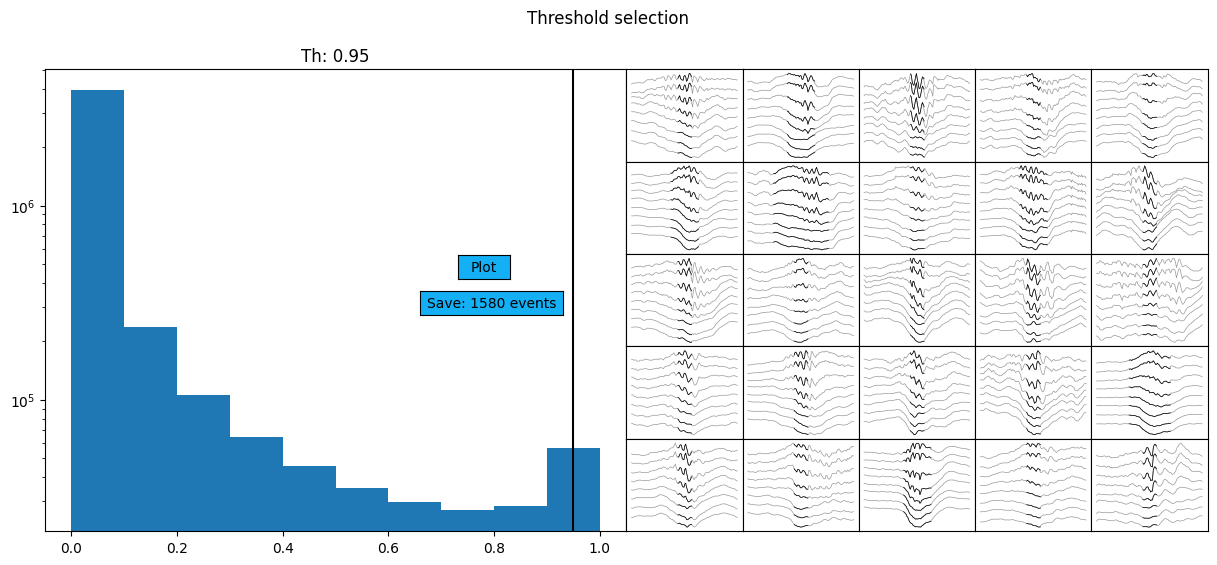

In [94]:
# Get the intervals of the SWRs
# NOTE: the function doesn't work without a threshold on a notebook. We need to set a threshold. 
predictions = rippl_AI.get_intervals(y=SWR_prob, LFP_norm=LFP_norm, sf=1250, win_size=100, threshold=0.95, 
                                     file_path='C:/Users/RECORDING/Athina/Ripples/SWR_predictions_' + region + '_' + arch + '.txt')

#### Compare Valter's model to the CNN1D-1 from the rippl_AI repository.
They are the same model.

In [120]:
# Load and pre-trained model (CNN1D) from previous repository: The
def get_spwr_times(loaded_data, threshold, fs):
    
    '''''''''''''''''
    DOWNSAMPLE AND NORMALIZE AND GENERATE WINDOWS
    '''''''''''''''''
    # from load_data import z_score_normalization, downsample_data
    # Downsample data
    downsampled_fs = 1250
    print("Downsampling data from %d Hz to %d Hz..."%(fs, downsampled_fs), end=" ")
    LFP_norm = aux_fcn.downsample_data(loaded_data, fs, downsampled_fs)
    print("Done!")

    # Normalize it with z-score
    print("Normalizing data...", end=" ")
    LFP_norm = aux_fcn.z_score_normalization(LFP_norm)
    print("Done!")
    print("Shape of loaded data after downsampling and z-score: ", np.shape(LFP_norm))

   
    '''''''''''''''''
    DETECT RIPPLES PROBABILITIES
    '''''''''''''''''
    # This is similar to the function prediction_parser in rippl_AI.py
    print("Detecting ripples probabilities...", end=" ")
    for filename in os.listdir(os.path.join(rippl_AI_repo,'optimized_models')):
        if f'CNN1D_{str(1)}' in filename:
            break
    print(filename)
    sp=filename.split('_')
    n_channels=int(sp[2][2])
    timesteps=int(sp[4][2:])

    input_len=LFP_norm.shape[0]  # normalized LFP

    data=LFP_norm[:len(LFP_norm)-len(LFP_norm)%timesteps,:].reshape(-1,timesteps,n_channels)
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    # model = keras.models.load_model(r"I:\Dropbox (Yanik Lab)\PeterG\source\repos\spwr-project\cnn-ripple\model", compile=False)
    model = keras.models.load_model(os.path.join('optimized_models',filename), compile=False)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)

    windowed_signal = model.predict(data, verbose=True)
    windowed_signal=windowed_signal.reshape(-1)
    y_predict=np.zeros(shape=(input_len,1,1))
    for i,window in enumerate(windowed_signal):
        y_predict[i*timesteps:(i+1)*timesteps]=window
                
    predictions_prob = y_predict.reshape(-1)
    
    print("Done!")


    '''''''''''''''''
    DETECT RIPPLES
    '''''''''''''''''
    print("Getting detected ripples indexes and times...", end=" ")
    predictions = rippl_AI.get_intervals(y=predictions_prob, LFP_norm=LFP_norm, sf=downsampled_fs, win_size=100, threshold=threshold, 
                                        file_path='C:/Users/RECORDING/Athina/Ripples/sf_compare/' + filename + '_predictions_' + region + '_' + arch +'_.txt')

    print("Done!")


    '''''''''''''''''
    MERGE RIPPLES
    '''''''''''''''''
    #pred_indexes[:8, :]
    #pred_times

    ### Merge spwr ripples ###

    # buffer=0.0128

    # num_spwrs = 0
    # spwr_start = pred_times[0, 0]
    # spwr_end = pred_times[0, 1]

    # curr_end = pred_times[0, 1]
    # spwrs_times = []

    # for i, (start_t, end_t) in enumerate(pred_times[1:, :]):
    #     if (start_t <= curr_end+buffer):
    #         curr_end = end_t
    #     else:
    #         spwr_end = curr_end
    #         spwrs_times.append((spwr_start, spwr_end))
    #         spwr_start = start_t
    #         curr_end = end_t

    # spwrs_times_array = np.array(spwrs_times)
    # spwrs_indexes_array = (spwrs_times_array * fs).astype(int)

    # return spwrs_times_array, pred_times
    return predictions

Downsampling data from 2000 Hz to 1250 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (4550304, 8)
Detecting ripples probabilities... CNN1D_1_Ch8_W60_Ts16_OGmodel12
8888/8888 [==============================] - 11s 1ms/step
Done!
Getting detected ripples indexes and times... (1580, 2)
(1580, 2)


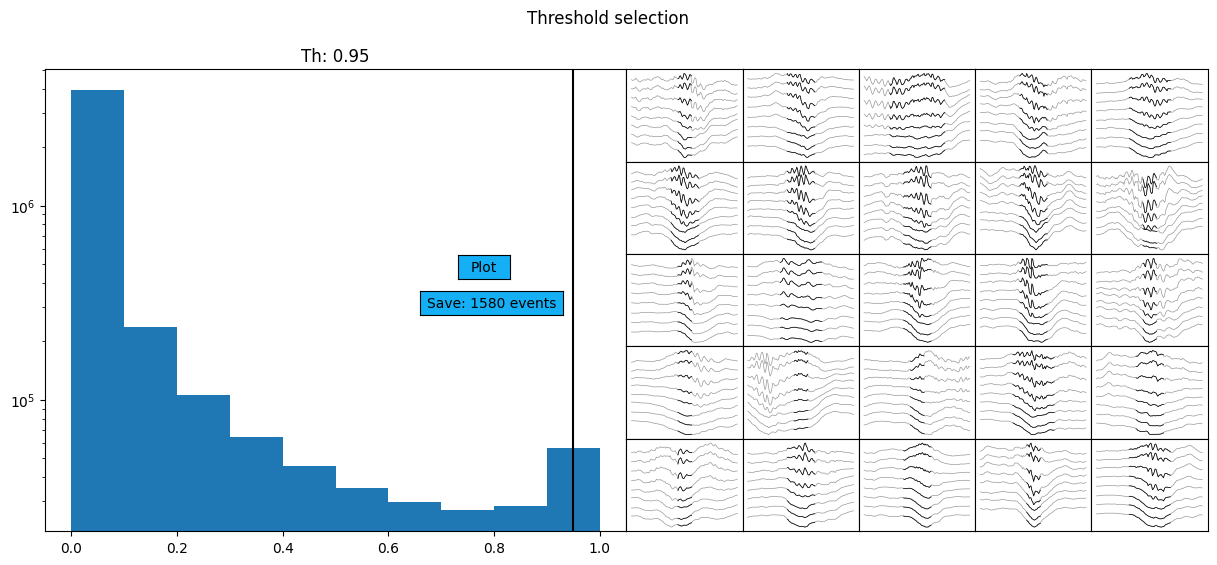

Done!


In [122]:
# Get predictions and performance using the CNN1D-1
predictions = get_spwr_times(loaded_data=lfp[:,:8], threshold=0.95, fs=2000)

#### Compare the performance of the current CNN1D model with 2000Hz sf

In [3]:
# Define variables
filtered = True # whether to load from the LFP.mat file (downsampled) or from the .lfp file (filtered and downsampled)
comparison = True # whether to compare CNN-detected SWRs to manually curated ones
animal = 'rTBY37'
sessname = '12_freely_behav_220705_125034' 
channels = [79, 88, 80, 87, 81, 86, 82, 85, 4, 53, 2, 56, 0, 55, 7, 58] 

# Comparison 
if comparison is True: 
    comp_dir = os.path.join(ripple_analysis_dir, 'performance/' + animal + '/' + sessname + '/')
    if not os.path.exists(comp_dir):
        os.makedirs(comp_dir)

    # Import curated ripples
    ripples_dir = "C:/Users/RECORDING/Athina/Ripples/curated_ripples/" + animal + "/" + sessname + "/"
    curated_ripples_dHPC_file = "curated_ripples_dHP.mat"
    curated_ripples_iHPC_file = "curated_ripples_iHP.mat"
    
    with h5py.File(os.path.join(ripples_dir, curated_ripples_dHPC_file), 'r') as f:
        ripples_dHPC_times = np.transpose(f['ripple_timestamps'][:])  # n_ripples x 2 (start and end of ripple)
    
    with h5py.File(os.path.join(ripples_dir, curated_ripples_iHPC_file), 'r') as f:
        ripples_iHPC_times = np.transpose(f['ripple_timestamps'][:])  # n_ripples x 2 (start and end of ripple)
    
    true_events = [ripples_dHPC_times, ripples_iHPC_times]
    
    print("Curated dHPC ripples timestamps shape: ", ripples_dHPC_times.shape)
    print("Curated iHPC ripples timestamps shape: ", ripples_iHPC_times.shape)

# Load LFP 
if filtered is False:
    lfp_dir = "I:/Dropbox (Yanik Lab)/Multiarea rat recordings/rTBY35/preprocessed_data_35/" + sessname
    lfp_file = "7_freely_behav_220511_152446_LFP.mat"  # this LFP file is already downsampled to 2000Hz
    
    with h5py.File(os.path.join(lfp_dir, lfp_file), 'r') as f:
        lfp = np.transpose(f['lfp']['data'][:])  # n_samples x n_channels 
else:
    lfp_dir = os.path.join(ripple_analysis_dir, 'lfp_data/', animal) 

    for file in os.listdir(lfp_dir):
        if sessname in file and '.lfp' in file:
            lfp_file = os.path.join(lfp_dir, file)
            break  

# Output dir
output_dir = "C:/Users/RECORDING/Athina/Ripples/" + "detection/" + animal + "/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Curated dHPC ripples timestamps shape:  (372, 2)
Curated iHPC ripples timestamps shape:  (225, 2)


In [4]:
# Load data (n_channels x n_samples)
print("Importing file: ", lfp_file)
lfp = import_lfp(raw_data_file=lfp_file, num_channels=16, channels=np.arange(0,16), sample_rate=2000)
lfp = np.transpose(lfp)

Importing file:  C:/Users/RECORDING/Athina/Ripples/lfp_data/rTBY37\12_freely_behav_220705_125034.amplifier_ds.lfp
Processing data indices from 0 to 1600000
Processing data indices from 1600000 to 3200000
Processing data indices from 3200000 to 4800000
Processing data indices from 4800000 to 6400000
Processing data indices from 6400000 to 8000000
Processing data indices from 8000000 to 9600000
Processing data indices from 9600000 to 11200000
Processing data indices from 11200000 to 12800000
Processing data indices from 12800000 to 14400000
Processing data indices from 14400000 to 16000000
Processing data indices from 16000000 to 17600000
Processing data indices from 17600000 to 19200000
Processing data indices from 19200000 to 20800000
Processing data indices from 20800000 to 22400000
Processing data indices from 22400000 to 24000000
Processing data indices from 24000000 to 25600000
Processing data indices from 25600000 to 27200000
Processing data indices from 27200000 to 28800000
Proce

Downsampling data at 1250 Hz...
Shape of downsampled data: (4526024, 8)
Normalizing data...
CNN1D_1_Ch8_W60_Ts16_OGmodel12
8840/8840 [==============================] - 12s 1ms/step
(1370, 2)
(1370, 2)


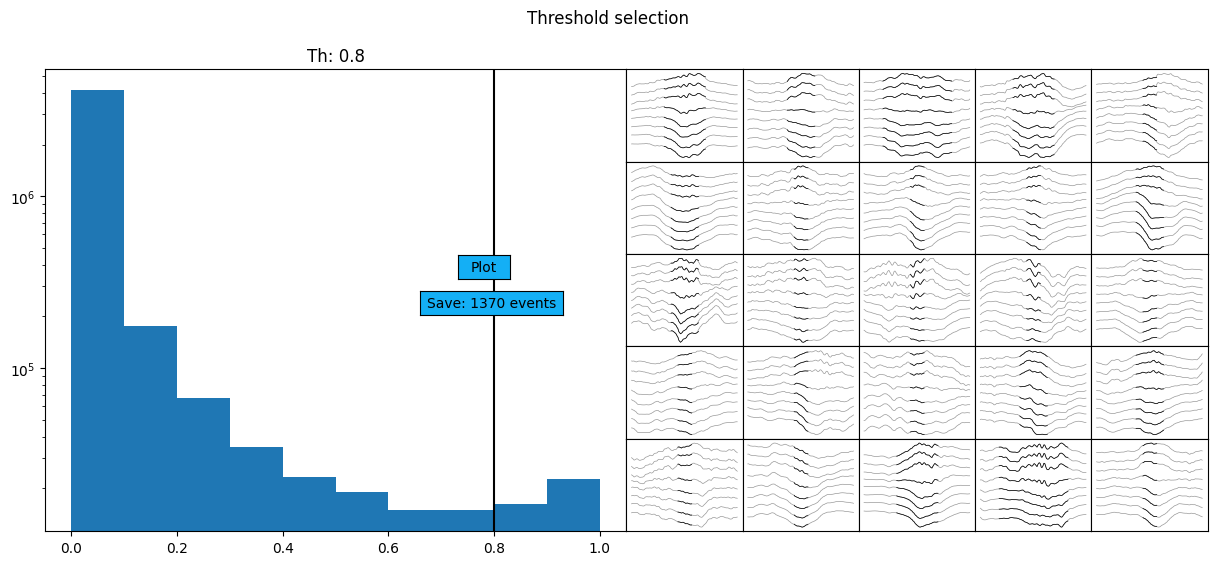

precision = 0.2605839416058394
recall = 0.9381720430107527
F1 = 0.4078771192960287
Downsampling data at 1250 Hz...
Shape of downsampled data: (4526024, 8)
Normalizing data...
CNN1D_1_Ch8_W60_Ts16_OGmodel12
8840/8840 [==============================] - 11s 1ms/step
(2, 2)
(2, 2)


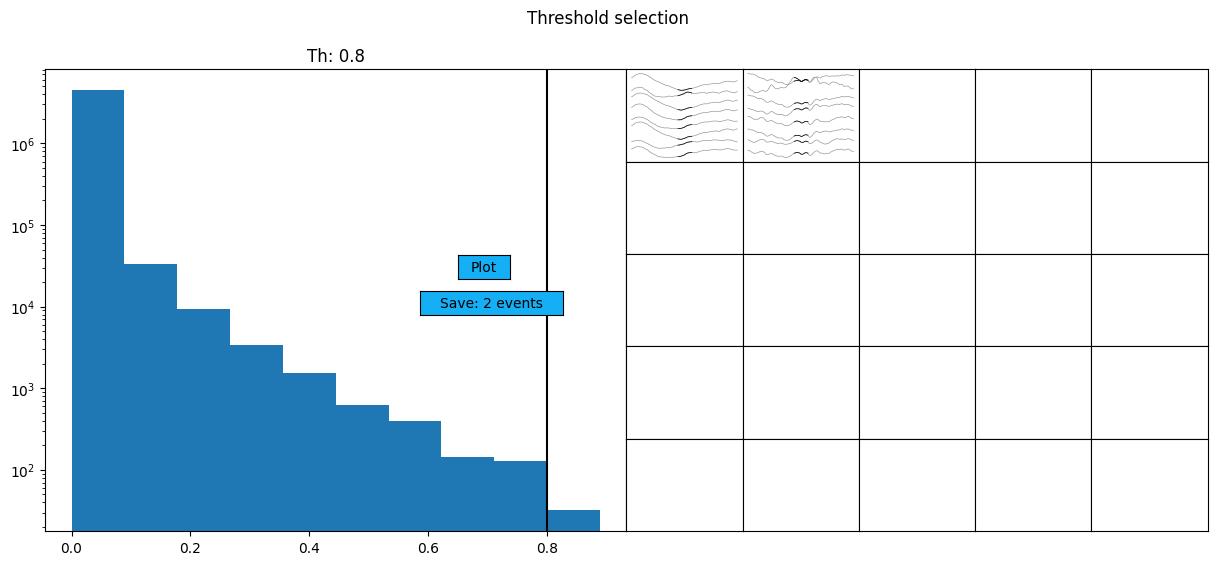

precision = 0.0
recall = 0.0
F1 = 0.0
Number of dHP spwrs:  1337
Number of iHP spwrs:  1
Total number spwrs:  1338
Done!


C:\Users/RECORDING/Athina/Github/rippl-AI\aux_fcn.py:580: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2. * (precision * recall) / (precision + recall)


In [14]:
# Fit the CNN1D model and get its predictions and performance (1250 Hz)
downsampled_fs = 1250
threshold = 0.8

regions = ['dHPC', 'iHPC']
spwrs_times_array = []

for r, region in enumerate(regions):
    # Choose channels 
    if region == 'dHPC':
        channels = np.arange(0,8)
    else:
        channels = np.arange(8,16)

    # Predictions
    current_dir = os.getcwd()
    os.chdir(rippl_AI_repo)
    SWR_prob, LFP_norm = rippl_AI.predict(lfp, sf=2000, arch='CNN1D', model_number=1, channels=channels)
    os.chdir(current_dir)
    
    predictions = rippl_AI.get_intervals(y=SWR_prob, LFP_norm=LFP_norm, sf=downsampled_fs, win_size=100, threshold=threshold)     

    # Performance 
    if comparison is True:
        performance = aux_fcn.get_performance(pred_events=predictions, true_events=true_events[r], threshold=0)[0:3]
        with open(os.path.join(comp_dir, f"performance_CNN1D_{str(downsampled_fs)}Hz_{region}.txt"), 'w') as f:
            f.write('\t'.join(['precision', 'recall', 'F1']) + '\n')
            f.write('\t'.join(map(str, performance)) + '\n')

    # Merge ripples
    buffer=0.0128  # seconds

    num_spwrs = 0
    spwr_start = predictions[0, 0]
    spwr_end = predictions[0, 1]

    curr_end = predictions[0, 1]
    spwrs_times = []

    for i, (start_t, end_t) in enumerate(predictions[1:, :]):
        if (start_t <= curr_end+buffer):
            curr_end = end_t
        else:
            spwr_end = curr_end
            spwrs_times.append((spwr_start, spwr_end))
            spwr_start = start_t
            curr_end = end_t

    spwrs_times_array.append(np.array(spwrs_times))

# Output to .mat files
all_spwrs_times = np.concatenate((spwrs_times_array[0], spwrs_times_array[1]))  # merge dHPC and iHPC

n_spwr_dHP = spwrs_times_array[0].shape[0]
n_spwr_iHP = spwrs_times_array[1].shape[0]
print("Number of dHP spwrs: ", n_spwr_dHP)
print("Number of iHP spwrs: ", n_spwr_iHP)
print("Total number spwrs: ", n_spwr_dHP + n_spwr_iHP)

listdHP = ['dHP']*n_spwr_dHP
listiHP = ['iHP']*n_spwr_iHP

labels = listdHP + listiHP

save_path = output_dir + str(downsampled_fs) + "Hz/" 
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
scipy.io.savemat(save_path + sessname + ".ripples.mat"
                 , {"spwr": all_spwrs_times, "labels": np.transpose(np.asarray(labels, dtype='object')), "threshold": threshold})
print("Done!")

Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (7241639, 8)
CNN1D_1_Ch8_W60_Ts16_OGmodel12
14144/14144 [==============================] - 18s 1ms/step
(1441, 2)
(1441, 2)


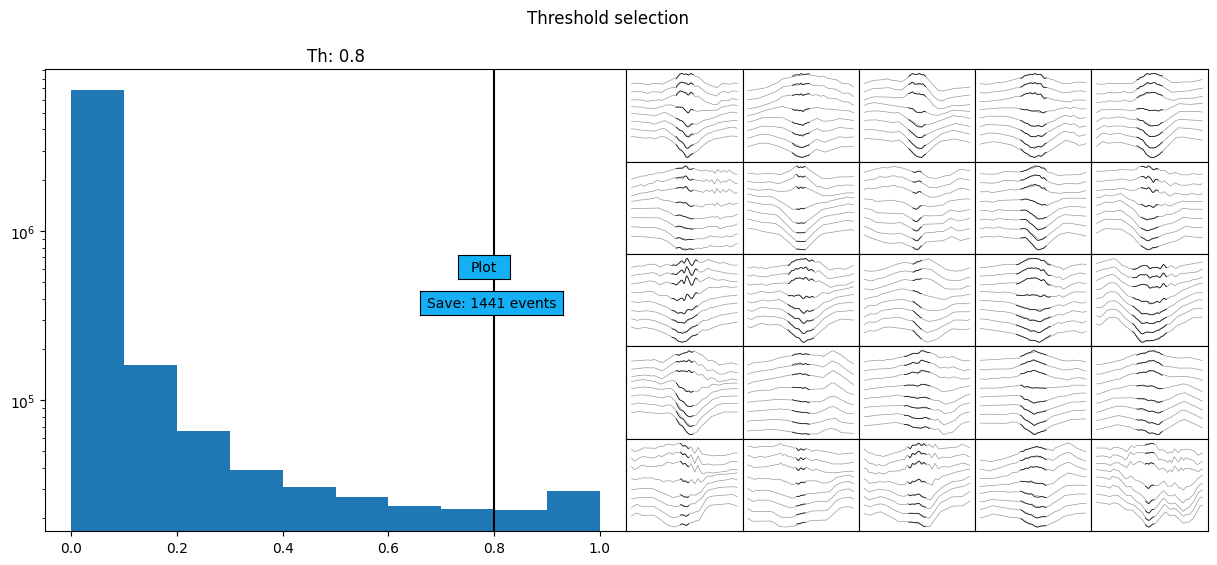

precision = 0.2539902845246357
recall = 0.9274193548387096
F1 = 0.39877024524038485
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (7241639, 8)
CNN1D_1_Ch8_W60_Ts16_OGmodel12
14144/14144 [==============================] - 19s 1ms/step
(1, 2)
(1, 2)


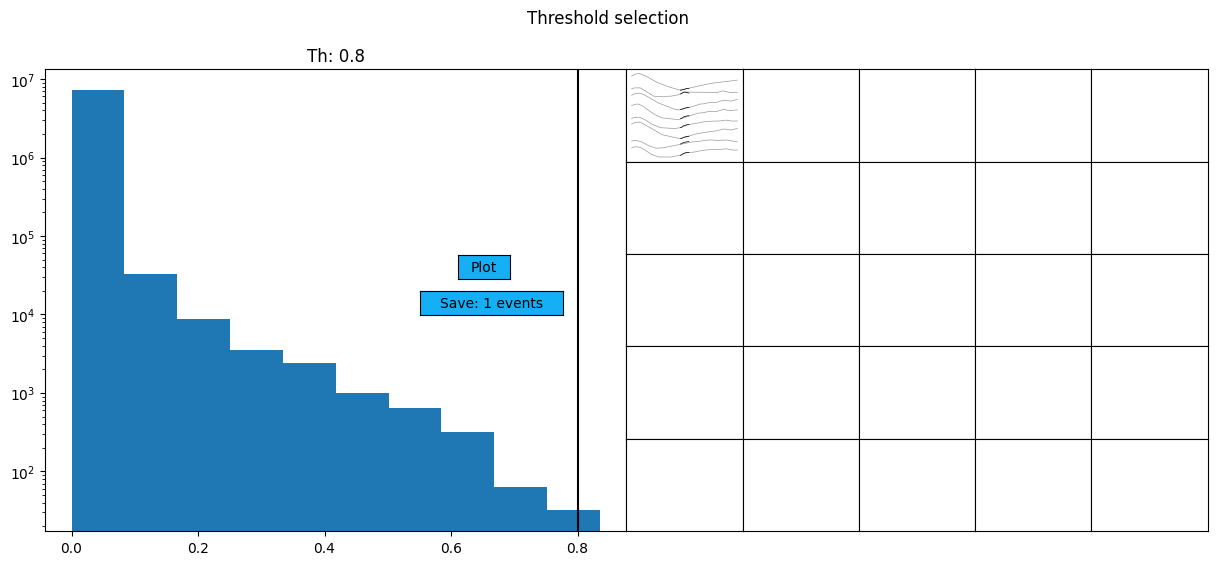

precision = 0.0
recall = 0.0
F1 = 0.0


C:\Users/RECORDING/Athina/Github/rippl-AI\aux_fcn.py:580: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2. * (precision * recall) / (precision + recall)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [6]:
# Fit the CNN1D model and get its predictions and performance (2000 Hz)
downsampled_fs = 2000
threshold = 0.8

regions = ['dHPC', 'iHPC']
spwrs_times_array = []

for r, region in enumerate(regions):
    # Choose channels 
    if region == 'dHPC':
        channels = np.arange(0,8)
    else:
        channels = np.arange(8,16)

    # Predictions
    LFP_norm = process_LFP_new(lfp, sf=2000, downsampled_fs=downsampled_fs, channels=channels)

    current_dir = os.getcwd()
    os.chdir(rippl_AI_repo)
    SWR_prob = aux_fcn.prediction_parser(LFP_norm, arch='CNN1D', model_number=1)        
    os.chdir(current_dir)

    predictions = rippl_AI.get_intervals(y=SWR_prob, LFP_norm=LFP_norm, sf=downsampled_fs, win_size=100, threshold=threshold)     

    # Performance 
    if comparison is True:
        performance = aux_fcn.get_performance(pred_events=predictions, true_events=true_events[r], threshold=0)[0:3]
        with open(os.path.join(comp_dir, f"performance_CNN1D_{str(downsampled_fs)}Hz_{region}.txt"), 'w') as f:
            f.write('\t'.join(['precision', 'recall', 'F1']) + '\n')
            f.write('\t'.join(map(str, performance)) + '\n')

    # Merge ripples
    buffer=0.0128  # seconds

    num_spwrs = 0
    spwr_start = predictions[0, 0]
    spwr_end = predictions[0, 1]

    curr_end = predictions[0, 1]
    spwrs_times = []

    for i, (start_t, end_t) in enumerate(predictions[1:, :]):
        if (start_t <= curr_end+buffer):
            curr_end = end_t
        else:
            spwr_end = curr_end
            spwrs_times.append((spwr_start, spwr_end))
            spwr_start = start_t
            curr_end = end_t

    spwrs_times_array.append(np.array(spwrs_times))

# Output to .mat files
all_spwrs_times = np.concatenate((spwrs_times_array[0], spwrs_times_array[1]))  # merge dHPC and iHPC

n_spwr_dHP = spwrs_times_array[0].shape[0]
n_spwr_iHP = spwrs_times_array[1].shape[0]
print("Number of dHP spwrs: ", n_spwr_dHP)
print("Number of iHP spwrs: ", n_spwr_iHP)
print("Total number spwrs: ", n_spwr_dHP + n_spwr_iHP)

listdHP = ['dHP']*n_spwr_dHP
listiHP = ['iHP']*n_spwr_iHP

labels = listdHP + listiHP

save_path = output_dir + str(downsampled_fs) + "Hz/" 
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
scipy.io.savemat(save_path + sessname + ".ripples.mat", 
                 {"spwr": all_spwrs_times, "labels": np.transpose(np.asarray(labels, dtype='object')), "threshold": threshold})
print("Done!")